In [2]:
# Built-in modules
import math
 
# Imports from Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import grover_operator, MCMTGate, ZGate
from qiskit.visualization import plot_distribution
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

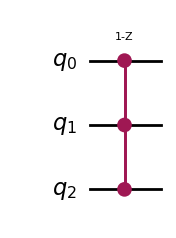

In [3]:
mcmt_ex = QuantumCircuit(3)
mcmt_ex.compose(MCMTGate(ZGate(), 3 - 1, 1), inplace=True)
mcmt_ex.draw(output="mpl", style="iqp")

In [8]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states
 
    Here we assume all input marked states have the same number of bits
 
    Parameters:
        marked_states (str or list): Marked states of oracle
 
    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])
 
    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bitstring to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bitstring
        zero_inds = [
            ind for ind in range(num_qubits) if rev_target.startswith("0", ind)
        ]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bitstring has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMTGate(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

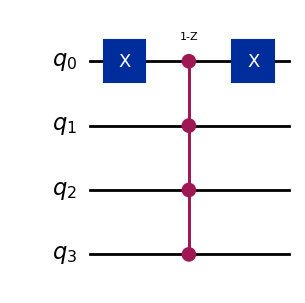

In [9]:
marked_states = ["1110"]
oracle = grover_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")

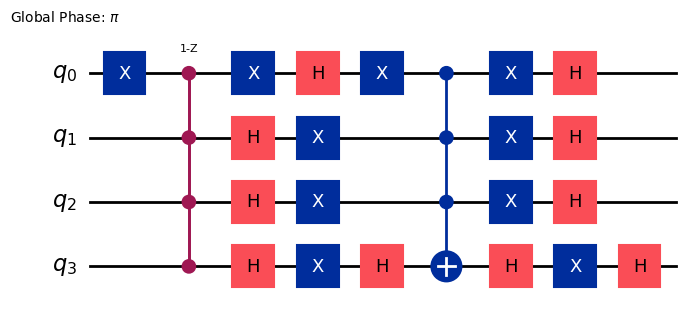

In [10]:
grover_op = grover_operator(oracle)
grover_op.decompose(reps=0).draw(output="mpl", style="iqp")

In [11]:
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
)
print(optimal_num_iterations)

3


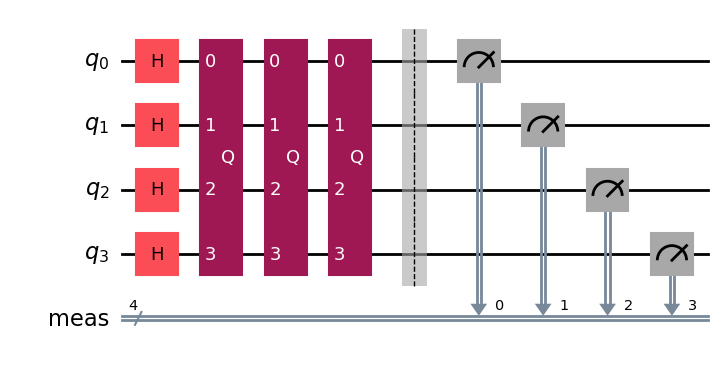

In [12]:
qc = QuantumCircuit(grover_op.num_qubits)
# Create even superposition of all basis states
qc.h(range(grover_op.num_qubits))
# Apply Grover operator the optimal number of times
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
# Measure all qubits
qc.measure_all()
qc.draw(output="mpl", style="iqp")

In [13]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(name='Paul')

print(service.backends())

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_torino')>]


In [14]:
#backend = service.backend('ibm_brisbane')
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_torino'

In [15]:
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
 
circuit_isa = pm.run(qc)
# The transpiled circuit will be very large. Only draw it if you are really curious.
# circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [16]:
print("The total depth is ", circuit_isa.depth())
print(
    "The depth of two-qubit gates is ",
    circuit_isa.depth(lambda instruction: instruction.operation.num_qubits == 2),
)

The total depth is  425
The depth of two-qubit gates is  111


In [17]:
# To run on a real quantum computer (this was tested on a Heron r2 processor and used 4 sec. of QPU time)
 
from qiskit_ibm_runtime import SamplerV2 as Sampler
 
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10_000
result = sampler.run([circuit_isa]).result()
dist = result[0].data.meas.get_counts()

In [18]:
# To run on local simulator:
# from qiskit.primitives import StatevectorSampler as Sampler
# sampler = Sampler()
# result = sampler.run([qc]).result()
# dist = result[0].data.meas.get_counts()

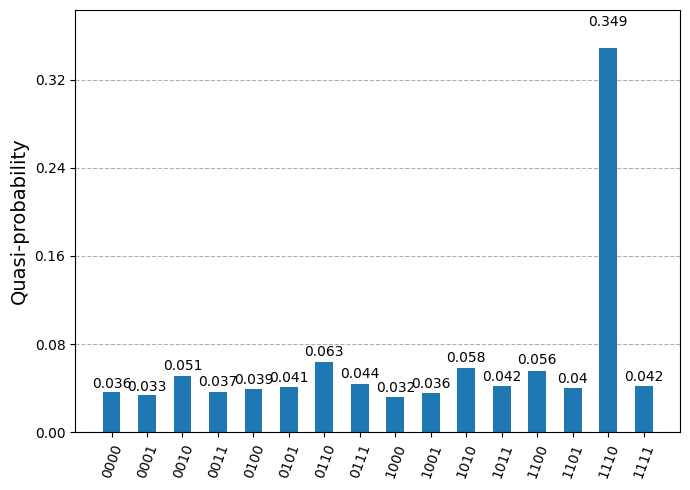

In [19]:
plot_distribution(dist)

<span style="font-size:22px">Activity 2</span>

In [20]:
# Modify the marked states to mark those you wish to target.
marked_states = ["1000"]
oracle = grover_oracle(marked_states)

In [21]:
from qiskit import qpy
 
# Save to a QPY file at a location where you can easily find it.
# You might want to specify a global address.
with open("/learning/ibm/fall_fest/paul_circuit.qpy", "wb") as f:
    qpy.dump(oracle, f)

In [22]:
from qiskit import qpy
 
# Load the circuit from your partner's qpy file from the folder where you saved it.
with open("/learning/ibm/fall_fest/paul_circuit.qpy", "rb") as f:
    circuits = qpy.load(f)
 
# qpy.load always returns a list of circuits
oracle_partner = circuits[0]
 
# You could visualize the circuit, but this would break the model of a query algorithm.
# oracle_partner.draw("mpl")

In [23]:
# Update according to your partner's number of target states.
num_marked_states = 1

In [24]:
grover_op = grover_operator(oracle_partner)
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(num_marked_states / 2**grover_op.num_qubits)))
)
qc = QuantumCircuit(grover_op.num_qubits)
qc.h(range(grover_op.num_qubits))
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
qc.measure_all()

In [25]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(name='Paul')
backend = service.least_busy(operational=True, simulator=False)
backend.name
 
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
circuit_partner_isa = pm.run(qc)

In [26]:
# To run on a real quantum computer (this was tested on a Heron r2 processor and used 4 seconds of QPU time)
 
from qiskit_ibm_runtime import SamplerV2 as Sampler
 
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10_000
result = sampler.run([circuit_partner_isa]).result()
dist = result[0].data.meas.get_counts()

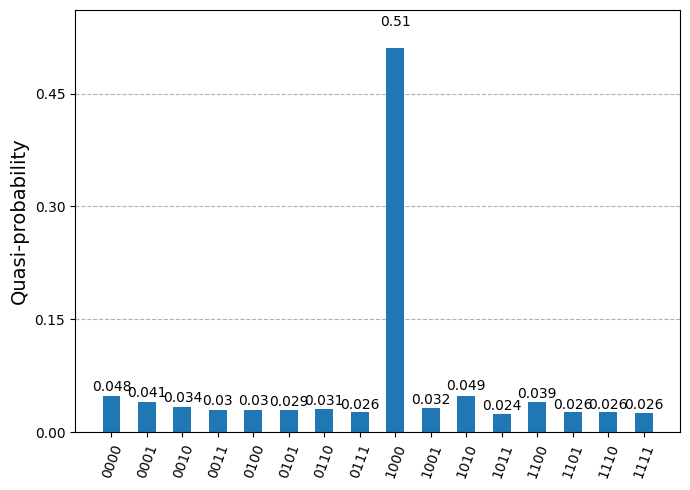

In [27]:
plot_distribution(dist)

<span style="font-size:22px">Activity 3</span>

In [28]:
from qiskit import QuantumCircuit
 
 
def grover_oracle_hamming_weight(num_qubits, target_weight):
    """
    Build a Grover oracle that marks all states with Hamming weight == target_weight.
 
    Parameters:
        num_qubits (int): Number of qubits in the circuit.
        target_weight (int): The Hamming weight to mark.
 
    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle.
    """
    qc = QuantumCircuit(num_qubits)
    marked_count = 0
    marked_list = []
    for x in range(2**num_qubits):
        bitstr = format(x, f"0{num_qubits}b")
        if bitstr.count("1") == target_weight:
            # Count the number of target states
            marked_count = marked_count + 1
            marked_list.append(bitstr)
            # Reverse for Qiskit bit order (qubit 0 is rightmost)
            rev_target = bitstr[::-1]
            zero_inds = [i for i, b in enumerate(rev_target) if b == "0"]
            # Apply X gates to 'open' controls (where bit is 0)
            qc.x(zero_inds)
            # Multi-controlled Z (as MCX conjugated by H)
            if num_qubits == 1:
                qc.z(0)
            else:
                qc.h(num_qubits - 1)
                qc.mcx(list(range(num_qubits - 1)), num_qubits - 1)
                qc.h(num_qubits - 1)
            # Undo X gates
            qc.x(zero_inds)
    return qc, marked_count, marked_list

['011', '101', '110']


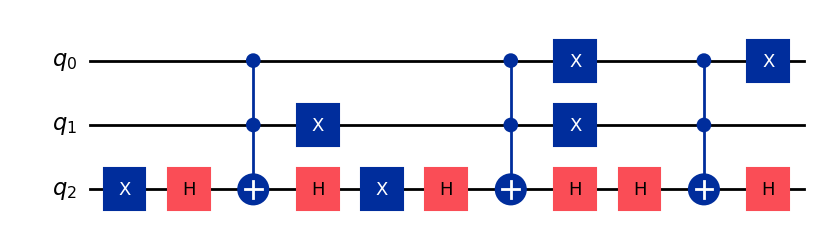

In [30]:
# Completing step 1
oracle, num_marked_states, marked_states = grover_oracle_hamming_weight(3, 2)
print(marked_states)
oracle.draw(output="mpl", style="iqp")

In [31]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
 
# Completing step 1
oracle, num_marked_states, marked_states = grover_oracle_hamming_weight(4, 2)
oracle.draw(output="mpl", style="iqp")
 
grover_op = grover_operator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
)
 
qc = QuantumCircuit(grover_op.num_qubits)
qc.h(range(grover_op.num_qubits))
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
qc.measure_all()
qc.draw(output="mpl", style="iqp")
 
# Step 2: Optimize for running on real quantum computers
 
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
print(backend.name)
 
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
circuit_isa = pm.run(qc)
 
# Step 3: Execute using Qiskit primitives
# To run on a real quantum computer (this was tested on a Heron r2 processor and used 4 seconds of QPU time)
 
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10_000
result = sampler.run([circuit_isa]).result()
dist = result[0].data.meas.get_counts()
 
# To run on local simulator:
# from qiskit.primitives import StatevectorSampler as Sampler
# sampler = Sampler()
# result = sampler.run([qc]).result()
# dist = result[0].data.meas.get_counts()

ibm_torino


In [32]:
print("The total depth is ", circuit_isa.depth())
print(
    "The depth of two-qubit gates is ",
    circuit_isa.depth(lambda instruction: instruction.operation.num_qubits == 2),
)

The total depth is  499
The depth of two-qubit gates is  130


In [33]:
num_marked_states

6

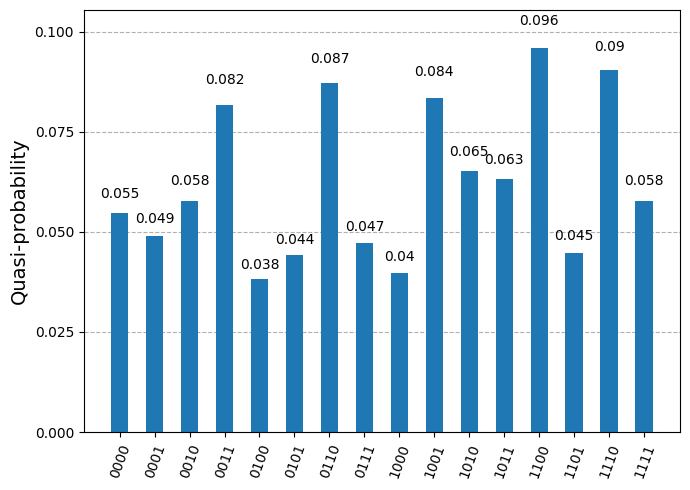

In [34]:
plot_distribution(dist)